# Interactive Visual Analytics with Folium

The launch success rate may depend on many factors such as payload mass, orbit type, and so on. It may also depend on the location and proximities of a launch site, i.e., the initial position of rocket trajectories. Finding an optimal location for building a launch site certainly involves many factors and hopefully we could discover some of the factors by analyzing the existing launch site locations.

### Objectives

This lab contains the following tasks:

*   **TASK 1:** Mark all launch sites on a map
*   **TASK 2:** Mark the success/failed launches for each site on the map
*   **TASK 3:** Calculate the distances between a launch site to its proximities

After completed the above tasks, you should be able to find some geographical patterns about launch sites.

In [33]:
import folium
import pandas as pd

# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

In [34]:
geo_data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
geo_data.to_csv('geo_data.csv', index=False)

In [50]:
geo_data.tail()

,Flight Number,Date,Time (UTC),Booster Version,Launch Site,Payload,Payload Mass (kg),Orbit,Customer,Landing Outcome,class,Lat,Long
51,48,2018-01-31,21:25:00,F9 FT B1032.2,CCAFS SLC-40,GovSat-1 / SES-16,4230.0,GTO,SES,Controlled (ocean),0,28.563197,-80.57682
52,50,2018-03-06,5:33:00,F9 B4 B1044,CCAFS SLC-40,Hispasat 30W-6 PODSat,6092.0,GTO,Hispasat NovaWurks,No attempt,0,28.563197,-80.57682
53,52,2018-04-02,20:30:00,F9 B4 B1039.2,CCAFS SLC-40,SpaceX CRS-14,2647.0,LEO (ISS),NASA (CRS),No attempt,0,28.563197,-80.57682
54,53,2018-04-18,22:51:00,F9 B4 B1045.1,CCAFS SLC-40,Transiting Exoplanet Survey Satellite (TESS),362.0,HEO,NASA (LSP),Success (drone ship),1,28.563197,-80.57682
55,56,2018-06-04,4:45:00,F9 B4 B1040.2,CCAFS SLC-40,SES-12,5384.0,GTO,SES,No attempt,0,28.563197,-80.57682


In [36]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = geo_data[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


Above coordinates are just plain numbers that can not give you any intuitive insights about where are those launch sites. If you are very good at geography, you can interpret those numbers directly in your mind. If not, that's fine too. Let's visualize those locations by pinning them on a map

We first need to create a folium Map object, with an initial center location to be NASA Johnson Space Center at Houston, Texas.

In [37]:
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

We could use folium.Circle to add a highlighted circle area with a text label on a specific coordinate. For example,

In [38]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))

In [39]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    icon = DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )

In [40]:
site_map.add_child(circle)
site_map.add_child(marker)

Now, let's add a circle for each launch site in data frame launch_sites

In [41]:
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


In [42]:
launch_sites_fg = folium.map.FeatureGroup()

for lat, long, site in zip(launch_sites_df.Lat, launch_sites_df.Long, launch_sites_df['Launch Site']):
    launch_sites_fg.add_child(
        folium.vector_layers.CircleMarker(
            [lat, long],
            radius=7,
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7
        ),
        folium.Circle(nasa_coordinate,
                      radius=1000, 
                      color='#d35400', 
                      fill=True).add_child(folium.Popup(site))

    )

# add pop-up text to each marker on the map
latitudes = list(launch_sites_df.Lat)
longitudes = list(launch_sites_df.Long)
labels = list(launch_sites_df['Launch Site'])

for lat, long, lab in zip(latitudes, longitudes, labels):
    folium.Marker([lat,long], popup=lab).add_to(site_map)

site_map.add_child(launch_sites_fg)

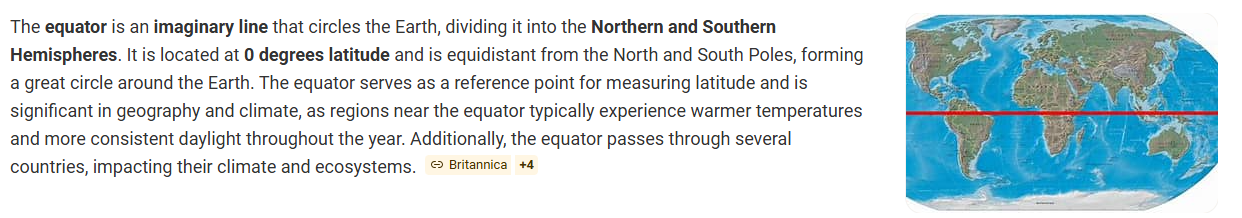

Now, you can explore the map by zoom-in/out the marked areas
, and try to answer the following questions:

*   Are all launch sites in proximity to the Equator line?
*   Are all launch sites in very close proximity to the coast?

## Task 2: Mark the success/failed launches for each site on the map

Next, let's try to enhance the map by adding the launch outcomes for each site, and see which sites have high success rates. Recall that data frame spacex_df has detailed launch records, and the class column indicates if this launch was successful or not

In [43]:
def color_class(row):
    return 'red' if row['class'] == 0 else 'green'

In [44]:
spacex_df['marker_color'] = spacex_df.apply(color_class, axis=1)
spacex_df.tail()

C:\Users\Paul Urias\AppData\Local\Temp\ipykernel_16804\1671378884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spacex_df['marker_color'] = spacex_df.apply(color_class, axis=1)


,Launch Site,Lat,Long,class,marker_color
51,CCAFS SLC-40,28.563197,-80.57682,0,red
52,CCAFS SLC-40,28.563197,-80.57682,0,red
53,CCAFS SLC-40,28.563197,-80.57682,0,red
54,CCAFS SLC-40,28.563197,-80.57682,1,green
55,CCAFS SLC-40,28.563197,-80.57682,0,red


For each launch result in spacex_df data frame, add a folium.Marker to marker_cluster

In [45]:
marker_cluster = MarkerCluster()
site_map.add_child(marker_cluster)

length = len(spacex_df)
for i in range(length):
    marker = folium.Marker(location=[spacex_df.loc[i, 'Lat'],spacex_df.loc[i, 'Long']],
                           icon= folium.Icon(color='white', icon_color=spacex_df.loc[i, 'marker_color']))
    marker_cluster.add_child(marker)

site_map

In [46]:
launch_sites_df

,Launch Site,Lat,Long
0,CCAFS LC-40,28.562302,-80.577356
1,CCAFS SLC-40,28.563197,-80.576820
2,KSC LC-39A,28.573255,-80.646895
3,VAFB SLC-4E,34.632834,-120.610745


In [47]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [52]:

site_map2 = folium.Map(location=nasa_coordinate, zoom_start=10)

latitudes = list(launch_sites_df.Lat)
longitudes = list(launch_sites_df.Long)
labels = list(launch_sites_df['Launch Site'])

#HEADQUARTERS 
# Circulo que al darle click sale el nombre de los HQ)
circle_headquarters = folium.Circle(nasa_coordinate, 
                                    radius=1000, 
                                    color='#d35400', 
                                    fill=True).add_child(folium.Popup('NASA Johnson Space Center'))

# Nombre fijo en el mapa de los headquarters 
marker_headquarters = folium.map.Marker(nasa_coordinate,
                                    icon = DivIcon(icon_size=(20,20),
                                                   icon_anchor=(0,0),
                                                   html='<div style="font-size: 18; color:black;"><b>%s</b></div>' % 'NASA JSC'))

site_map2.add_child(circle_headquarters)
site_map2.add_child(marker_headquarters)


#UNIQUE LAUNCHES SITES (Iteramos sobre el df de 4 rows)
lenght_df_sites = len(launch_sites_df)
for lat, long, site in zip(latitudes, longitudes, labels):
    folium.Marker([lat,long], popup=site).add_to(site_map2)
    folium.Circle([lat,long], radius=100, color='#d35400', fill=True).add_child(folium.Popup(site)).add_to(site_map2)


# Agregamos al cluster cada uno de los launches y su resultado (marker_color tiene red para fail y green para success)
# Iteramos sobre el df que tiene los datos de los launches
marker_cluster = MarkerCluster()
site_map2.add_child(marker_cluster)

length = len(spacex_df)
for i in range(length):
    marker = folium.Marker(location=[spacex_df.loc[i, 'Lat'],spacex_df.loc[i, 'Long']],
                           icon= folium.Icon(color='white', icon_color=spacex_df.loc[i, 'marker_color']))
    marker_cluster.add_child(marker)


#con la posicion del mouse se puede ver los numeros de latitud y longitud en el mapa
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map2.add_child(mouse_position)

#get the coordinates of the closest coastline and of the nearest launchsite and get de distance using the function
lat_costline = 28.56237
long_cosline = -80.5678
lat_launchsite = 28.56323
long_launchsite = -80.57685
distance_coastline = calculate_distance(lat_launchsite, long_launchsite, lat_costline, long_cosline)

lat_cost_vafb_slc_4e = 34.63474
long_cost_vafb_slc_4e = -120.62529
lat_launchsite_vafb_slc_4e = 34.63293
long_launchsite_vafb_slc_4e = -120.61079
dist_coast_vafb_slc_4e = calculate_distance(lat_launchsite_vafb_slc_4e, long_launchsite_vafb_slc_4e, lat_cost_vafb_slc_4e, long_cost_vafb_slc_4e)

lat_road_ksc_lc_394 = 28.5729
long_raod_ksc_lc_394 = -80.65543
lat_site_ksc_lc_394 = 28.57329
long_site_ksc_lc_394 = -80.64691
dist_road_ksc_lc_394 = calculate_distance(lat_site_ksc_lc_394, long_site_ksc_lc_394, lat_road_ksc_lc_394, long_raod_ksc_lc_394)




#poner marker en el coast coordinates with the distance
distance_marker = folium.Marker(location=[lat_costline, long_cosline],
                                icon=DivIcon(icon_size=(40,40),
                                             icon_anchor=(0,0),
                                            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline)))
site_map2.add_child(distance_marker)


dist_mark_cost_vafb_slc_4e = folium.Marker(location=[lat_cost_vafb_slc_4e, long_cost_vafb_slc_4e],
                                icon=DivIcon(icon_size=(40,40),
                                             icon_anchor=(0,0),
                                            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(dist_coast_vafb_slc_4e)))
site_map2.add_child(dist_mark_cost_vafb_slc_4e)


dist_mark_road_ksc_lc_394 = folium.Marker(location=[lat_road_ksc_lc_394, long_raod_ksc_lc_394],
                                icon=DivIcon(icon_size=(40,40),
                                             icon_anchor=(0,0),
                                            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(dist_road_ksc_lc_394)))
site_map2.add_child(dist_mark_road_ksc_lc_394)


#linea de punto a punto
lines = folium.PolyLine(locations=[[lat_costline, long_cosline], [lat_launchsite, long_launchsite]], weight=1, color='blue', opacity=1.0, popup='Distance from coast to launchsite')
site_map2.add_child(lines)

lines_vafb_slc_4e = folium.PolyLine(locations=[[lat_cost_vafb_slc_4e, long_cost_vafb_slc_4e], [lat_launchsite_vafb_slc_4e, long_launchsite_vafb_slc_4e]], weight=1, color='blue', opacity=1.0, popup='Distance from coast to launchsite')
site_map2.add_child(lines_vafb_slc_4e)

lines_ksc_lc_394 = folium.PolyLine(locations=[[lat_road_ksc_lc_394, long_raod_ksc_lc_394], [lat_site_ksc_lc_394, long_site_ksc_lc_394]], weight=1, color='blue', opacity=1.0, popup='Distance from main road to launchsite')
site_map2.add_child(lines_ksc_lc_394)



site_map2

After you plot distance lines to the proximities, you can answer the following questions easily:

*   Are launch sites in close proximity to railways?
*   Are launch sites in close proximity to highways?
*   Are launch sites in close proximity to coastline?
*   Do launch sites keep certain distance away from cities?

Also please try to explain your findings.